In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cargar archivo CSV
df = pd.read_csv("Indicadores_Muestra.csv")
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.set_index('Fecha', inplace=True)

# -----------------------------
# 3. Imputación de Valores Faltantes
# -----------------------------

# Usamos KNN como aproximación al enfoque de Mariano y Murasawa
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)


In [9]:

# -----------------------------
# 4. Test de Estacionariedad y Transformación
# -----------------------------
stationary_data = pd.DataFrame(index=df_imputed.index)
adf_results = {}

for col in df_imputed.columns:
    series = df_imputed[col]
    result = adfuller(series.dropna())
    pval = result[1]
    if pval < 0.05:
        stationary_data[col] = series
        adf_results[col] = "Estacionaria"
    else:
        if (series > 0).all():
            stationary_data[col] = np.log(series).diff().dropna()
            adf_results[col] = "No estacionaria - log-diff aplicada"
        else:
            stationary_data[col] = series.diff().dropna()
            adf_results[col] = "No estacionaria - diff aplicada"

stationary_data.dropna(inplace=True)





In [10]:

# -----------------------------
# 5. Modelado: ARIMA, VAR, SNARIMAX
# -----------------------------

# Dividir entre entrenamiento y prueba
train_size = int(len(stationary_data) * 0.8)
train, test = stationary_data.iloc[:train_size], stationary_data.iloc[train_size:]

# ARIMA sobre PIB
arima_model = ARIMA(train['PIB'], order=(1,0,1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test['PIB'], arima_forecast)
arima_mae = mean_absolute_error(test['PIB'], arima_forecast)
print("\nARIMA resumen:\n", arima_fit.summary())
print(f"ARIMA MSE: {arima_mse:.4f}, MAE: {arima_mae:.4f}")

# -----------------------------
# VAR con todas las variables (sin Consumer_Confidence)
# -----------------------------
var_columns = [col for col in train.columns if col != 'Consumer_Confidence']
var_model = VAR(train[var_columns])
var_results = var_model.fit(maxlags=5, ic='aic')
var_forecast = var_results.forecast(train[var_columns].values[-var_results.k_ar:], steps=len(test))
var_forecast_df = pd.DataFrame(var_forecast, index=test.index, columns=var_columns)
var_mse = mean_squared_error(test['PIB'], var_forecast_df['PIB'])
var_mae = mean_absolute_error(test['PIB'], var_forecast_df['PIB'])

print("\nVAR resumen:\n", var_results.summary())
print(f"VAR MSE: {var_mse:.4f}, MAE: {var_mae:.4f}")

# -----------------------------
# SNARIMAX sobre PIB con variable exógena: Consumer_Confidence
# -----------------------------
exog_var = 'Consumer_Confidence'
snarimax_model = SARIMAX(
    train['PIB'],
    exog=train[[exog_var]],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 12)
)
snarimax_fit = snarimax_model.fit(disp=False)
snarimax_forecast = snarimax_fit.forecast(steps=len(test), exog=test[[exog_var]])
snarimax_mse = mean_squared_error(test['PIB'], snarimax_forecast)
snarimax_mae = mean_absolute_error(test['PIB'], snarimax_forecast)

print("\nSNARIMAX resumen:\n", snarimax_fit.summary())
print(f"SNARIMAX MSE: {snarimax_mse:.4f}, MAE: {snarimax_mae:.4f}")

c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



ARIMA resumen:
                                SARIMAX Results                                
Dep. Variable:                    PIB   No. Observations:                  374
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 265.219
Date:                Sun, 18 May 2025   AIC                           -522.439
Time:                        21:35:38   BIC                           -506.742
Sample:                    07-01-1986   HQIC                          -516.206
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.688      0.492      -0.002       0.001
ar.L1         -0.3835      0.056     -6.882      0.000      -0.493      -0.274
ma.L1         -0.8607      0.028   

c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



SNARIMAX resumen:
                                      SARIMAX Results                                      
Dep. Variable:                                PIB   No. Observations:                  374
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 452.965
Date:                            Sun, 18 May 2025   AIC                           -893.930
Time:                                    21:35:39   BIC                           -870.385
Sample:                                07-01-1986   HQIC                          -884.582
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Consumer_Confidence    -0.0008      0.001     -0.758      0.448      -0.003 

c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# -----------------------------
# 5. Modelado: ARIMA, VAR, SNARIMAX y comparación
# -----------------------------

# Dividir entre entrenamiento y prueba
train_size = int(len(stationary_data) * 0.8)
train, test = stationary_data.iloc[:train_size], stationary_data.iloc[train_size:]

# ARIMA sobre PIB
arima_model = ARIMA(train['PIB'], order=(1,0,1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test['PIB'], arima_forecast)
arima_mae = mean_absolute_error(test['PIB'], arima_forecast)
print("\nARIMA resumen:\n", arima_fit.summary())
print(f"ARIMA MSE: {arima_mse:.4f}, MAE: {arima_mae:.4f}")

# VAR con todas las variables
var_model = VAR(train)
var_results = var_model.fit(maxlags=5, ic='aic')
var_forecast = var_results.forecast(train.values[-var_results.k_ar:], steps=len(test))
var_forecast_df = pd.DataFrame(var_forecast, index=test.index, columns=train.columns)


c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



ARIMA resumen:
                                SARIMAX Results                                
Dep. Variable:                    PIB   No. Observations:                  374
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 265.219
Date:                Sun, 18 May 2025   AIC                           -522.439
Time:                        21:35:40   BIC                           -506.742
Sample:                    07-01-1986   HQIC                          -516.206
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.688      0.492      -0.002       0.001
ar.L1         -0.3835      0.056     -6.882      0.000      -0.493      -0.274
ma.L1         -0.8607      0.028   

Errores VAR Pre-2008: 0.16166632575017964 0.37936038548355605
Errores VAR Post-2008: 1.0955849128742103 1.0111245034353504


c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\diaro\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


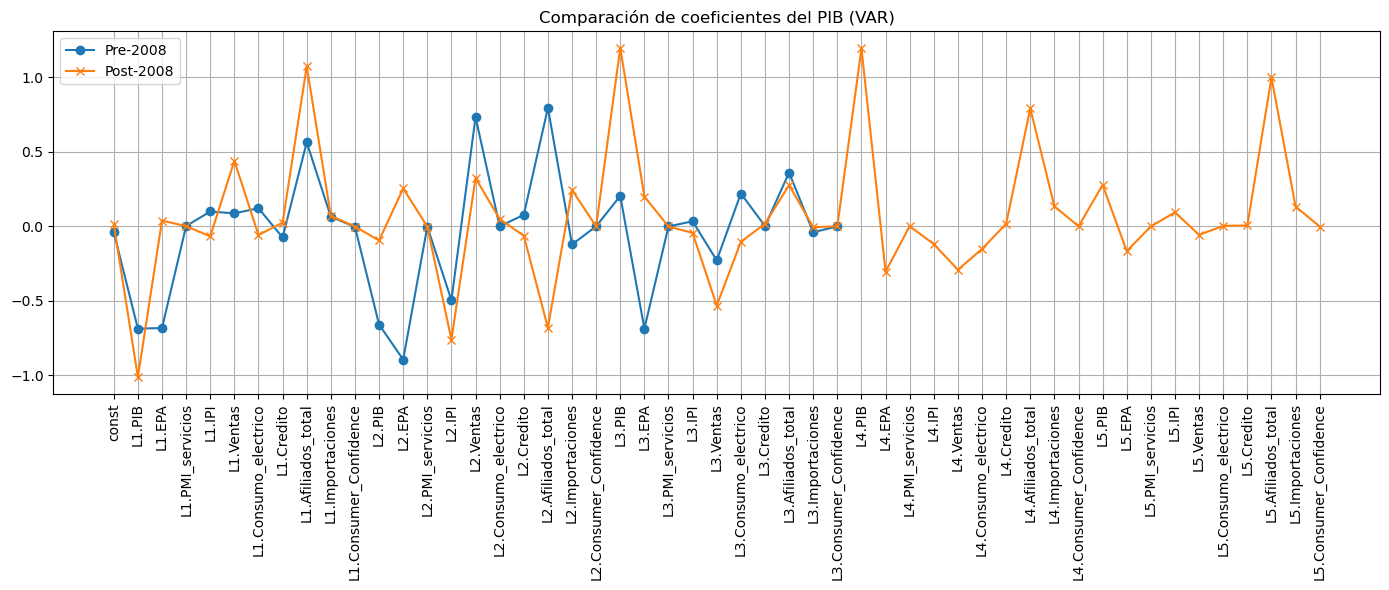

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

cutoff = '2008-01-01'
pre_data = stationary_data.loc[:cutoff]
post_data = stationary_data.loc[cutoff:]

# Entrenamiento VAR
model_pre = VAR(pre_data).fit(maxlags=5, ic='aic')
model_post = VAR(post_data).fit(maxlags=5, ic='aic')

# Forecast comparativo
forecast_pre = model_pre.forecast(pre_data.values[-model_pre.k_ar:], steps=5)
forecast_post = model_post.forecast(post_data.values[-model_post.k_ar:], steps=5)

true_pre = pre_data.iloc[-5:]['PIB']
true_post = post_data.iloc[-5:]['PIB']

pred_pre = pd.DataFrame(forecast_pre, columns=pre_data.columns).iloc[:, 0]
pred_post = pd.DataFrame(forecast_post, columns=post_data.columns).iloc[:, 0]

print("Errores VAR Pre-2008:", mean_squared_error(true_pre, pred_pre), mean_absolute_error(true_pre, pred_pre))
print("Errores VAR Post-2008:", mean_squared_error(true_post, pred_post), mean_absolute_error(true_post, pred_post))

# Comparación visual de coeficientes
coef_pre = model_pre.params.filter(like='PIB')
coef_post = model_post.params.filter(like='PIB')

plt.figure(figsize=(14, 6))
plt.plot(coef_pre.index, coef_pre.iloc[:, 0], marker='o', label='Pre-2008')
plt.plot(coef_post.index, coef_post.iloc[:, 0], marker='x', label='Post-2008')
plt.xticks(rotation=90)
plt.title("Comparación de coeficientes del PIB (VAR)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig("comparacion_coeficientes_pib_VAR.png", dpi=300)
plt.show()
